# German credit risk prediciton with Scikit-learn for model monitoring

This notebook should be run in a Watson Studio project, using **Default Python 3.9** runtime environment. It requires service credentials for the following Cloud services:
  * Watson Machine Learning V4

The notebook will train, create and deploy a German Credit Risk model.

### Learning goals

In this notebook, you will learn how to:

-  Explore data
-  Prepare data for training and evaluation
-  Create a scikit-learn pipeline
-  Train and evaluate a model
-  Store a model in the Watson Machine Learning (WML) repository
-  Deploy and score the model

### Contents

- [Setup](#setup)
- [Explore Data](#explore)
- [Create a model](#create_model)
- [Publish the model](#publish_model)
- [Deploy and score](#deploy_model)
- [Clean up](#cleanup)
- [Summary](#summary)


<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [ ]:
apikey = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [ ]:
wml_credentials = {
    "apikey": apikeyv,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install -U ibm-watson-machine-learning

In [2]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [ ]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

In next cells, you will need to paste some credentials to Cloud Object Storage. If you haven't worked with COS yet please visit [getting started with COS tutorial](https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-getting-started). 
You can find `COS_API_KEY_ID` and `COS_RESOURCE_CRN` variables in **_Service Credentials_** in menu of your COS instance. Used COS Service Credentials must be created with _Role_ parameter set as Writer. Later training data file will be loaded to the bucket of your instance and used as training refecence in subsription.  
`COS_ENDPOINT` variable can be found in **_Endpoint_** field of the menu.

In [ ]:
COS_API_KEY_ID = "***"
COS_RESOURCE_CRN = "***" 
COS_ENDPOINT = "***"
IAM_AUTH_ENDPOINT = "***"
BUCKET_NAME = "***" 

## Run the notebook

At this point, the notebook is ready to run. You can either run the cells one at a time, or click the **Kernel** option above and select **Restart and Run All** to run all the cells.

In this section you will learn how to train Scikit-learn model and next deploy it as web-service using Watson Machine Learning service.

## Load the training data from github

In [5]:
!rm german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv

--2020-10-07 14:32:17--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: 'german_credit_data_biased_training.csv'

german_credit_data_ 100%[===================>] 673.46K   700KB/s    in 1.0s    

2020-10-07 14:32:19 (700 KB/s) - 'german_credit_data_biased_training.csv' saved [689622/689622]



In [6]:
import numpy as np
import pandas as pd

training_data_file_name = "german_credit_data_biased_training.csv"
data_df = pd.read_csv(training_data_file_name)

## Explore data <a name="explore"></a>

In [7]:
data_df.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


In [8]:
print('Columns: ', list(data_df.columns))
print('Number of columns: ', len(data_df.columns))

Columns:  ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'Risk']
Number of columns:  21


As you can see, the data contains twenty one fields. `Risk` field is the one you would like to predict using feedback data.

In [9]:
print('Number of records: ', data_df.Risk.count())

Number of records:  5000


In [10]:
target_count = data_df.groupby('Risk')['Risk'].count()
target_count

Risk
No Risk    3330
Risk       1670
Name: Risk, dtype: int64

## Visualize data

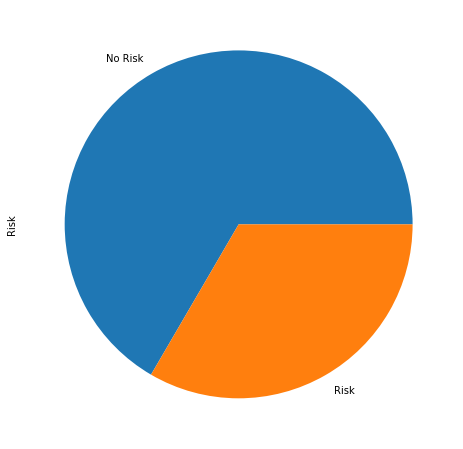

In [12]:
target_count.plot.pie(figsize=(8, 8));

## Save training data to Cloud Object Storage

In [ ]:
import ibm_boto3
from ibm_botocore.client import Config, ClientError

cos_client = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=IAM_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [ ]:
with open(training_data_file_name, "rb") as file_data:
    cos_client.Object(BUCKET_NAME, training_data_file_name).upload_fileobj(
        Fileobj=file_data
    )

## Create a model <a name="create_model"></a>
In this section you will learn how to:

- Prepare data for training a model
- Create machine learning pipeline
- Train a model

In [15]:
MODEL_NAME = "Scikit German Risk Model WML V4"

DEPLOYMENT_NAME = "Scikit German Risk Deployment WML V4"

### You will start with importing required libraries

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### Splitting the data into train and test

In [17]:
train_data, test_data = train_test_split(data_df, test_size=0.2)

### Preparing the pipeline

In [18]:
features_idx = np.s_[0:-1]
all_records_idx = np.s_[:]
first_record_idx = np.s_[0]

In this step you will encode target column labels into numeric values. You can use `inverse_transform` to decode numeric predictions into labels.

In [19]:
string_fields = [type(fld) is str for fld in train_data.iloc[first_record_idx, features_idx]]
ct = ColumnTransformer([("ohe", OneHotEncoder(), list(np.array(train_data.columns)[features_idx][string_fields]))])
clf_linear = SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-5)

pipeline_linear = Pipeline([('ct', ct), ('clf_linear', clf_linear)])

### Train a model

In [20]:
risk_model = pipeline_linear.fit(train_data.drop('Risk', axis=1), train_data.Risk)

### Evaluate the model

In [21]:
from sklearn.metrics import roc_auc_score

predictions = risk_model.predict(test_data.drop('Risk', axis=1))
indexed_preds = [0 if prediction=='No Risk' else 1 for prediction in predictions]

real_observations = test_data.Risk.replace('Risk', 1)
real_observations = real_observations.replace('No Risk', 0).values

auc = roc_auc_score(real_observations, indexed_preds)
print(auc)

0.7470097587160887


## Publish the model <a name="publish_model"></a>

In this section, the notebook uses the supplied Watson Machine Learning credentials to save the model (including the pipeline) to the WML instance. Previous versions of the model are removed so that the notebook can be run again, resetting all data for another demo.

In [22]:
import json

In [23]:
software_spec_uid = client.software_specifications.get_id_by_name("default_py3.8")
print("Software Specification ID: {}".format(software_spec_uid))
model_props = {
    client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

Software Specification ID: e4429883-c883-42b6-87a8-f419d64088cd


In [24]:
print("Storing model ...")

published_model_details = client.repository.store_model(model=risk_model, meta_props=model_props, training_data=data_df.drop(["Risk"], axis=1), training_target=data_df.Risk)
model_uid = client.repository.get_model_uid(published_model_details)
print("Done")
print("Model ID: {}".format(model_uid))

Storing model ...
Done
Model ID: 640a63b0-5dd9-488e-8661-bfa59aab517b


## Deploy and score <a name="deploy_model"></a>

The next section of the notebook deploys the model as a RESTful web service in Watson Machine Learning. The deployed model will have a scoring URL you can use to send data to the model for predictions.

In [25]:
print("Deploying model...")
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}
deployment = client.deployments.create(model_uid, meta_props=metadata)
deployment_uid = client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '640a63b0-5dd9-488e-8661-bfa59aab517b' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='3547145a-984a-4260-84b2-ae109f4d0416'
------------------------------------------------------------------------------------------------


Model id: 640a63b0-5dd9-488e-8661-bfa59aab517b
Deployment id: 3547145a-984a-4260-84b2-ae109f4d0416


## Score the model

In [26]:
fields = ["CheckingStatus", "LoanDuration", "CreditHistory", "LoanPurpose", "LoanAmount", "ExistingSavings",
                  "EmploymentDuration", "InstallmentPercent", "Sex", "OthersOnLoan", "CurrentResidenceDuration",
                  "OwnsProperty", "Age", "InstallmentPlans", "Housing", "ExistingCreditsCount", "Job", "Dependents",
                  "Telephone", "ForeignWorker"]
values = [
            ["no_checking", 13, "credits_paid_to_date", "car_new", 1343, "100_to_500", "1_to_4", 2, "female", "none", 3,
             "savings_insurance", 46, "none", "own", 2, "skilled", 1, "none", "yes"],
            ["no_checking", 24, "prior_payments_delayed", "furniture", 4567, "500_to_1000", "1_to_4", 4, "male", "none",
             4, "savings_insurance", 36, "none", "free", 2, "management_self-employed", 1, "none", "yes"],
        ]

scoring_payload = {"input_data": [{"fields": fields, "values": values}]}

In [27]:
predictions = client.deployments.score(deployment_uid, scoring_payload)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [0.7007022156515972, 0.29929778434840276]],
    ['No Risk', [0.7777043355811214, 0.2222956644188786]]]}]}

<a id="cleanup"></a>
##  Clean up 

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
##  Summary and next steps     

You successfully completed this notebook! 
 
You have finished the hands-on lab for IBM Watson Machine Learning. You created, published and deployed Scikit-Learn german credit risk model. 

Check out our <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts. 

You can now run the model monitoring [notebook](Monitor%20credit%20risk%20model%20with%20Watson%20Openscale.ipynb). You need to pass deployed model id in mentioned notebook

## Authors

Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Szymon Kucharczyk, Software Engineer at IBM Watson Machine Learning.

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.